In [2]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
#from object_detection.utils import config_util
#from object_detection.protos import pipeline_pb2
#from google.protobuf import text_format



2022-11-28 05:39:37.424938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-28 05:39:37.425768: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-28 05:39:37.425777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Load Data

In [3]:
#tf.data.Dataset.list_files

In [4]:
data_dir = '../Resources/Animals-10'

In [ ]:
os.listdir(os.path.join(data_dir,'butterfly'))

In [4]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 26179 files belonging to 10 classes.


2022-11-28 02:28:23.513506: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-28 02:28:23.514450: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-28 02:28:23.514505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-11-28 02:28:23.519155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
data_iterator = data.as_numpy_iterator()

In [6]:
batch = data_iterator.next()

In [7]:
batch[0].shape

(32, 256, 256, 3)

In [8]:
batch[1]

array([9, 8, 6, 4, 4, 0, 3, 7, 4, 6, 5, 1, 7, 5, 9, 2, 4, 0, 6, 9, 2, 2,
       9, 8, 4, 0, 3, 4, 6, 8, 7, 8], dtype=int32)

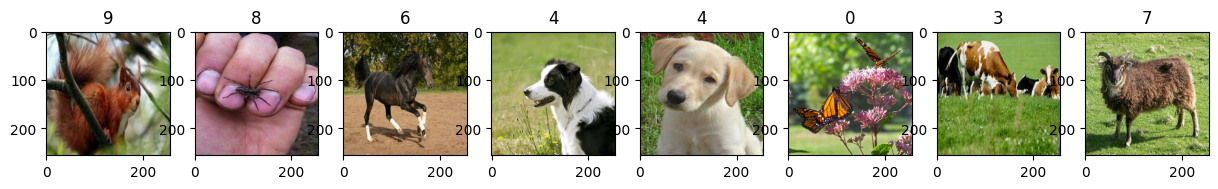

In [9]:
fig, ax = plt.subplots(ncols=8, figsize=(15,15))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
image_exts = ['jpeg','jpg','bmp','png']

#doesnt really work
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(iamge_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            

Issue with image ../Resources/Animals-10/butterfly/butterfly (1).jpg
Issue with image ../Resources/Animals-10/butterfly/butterfly (1).png
Issue with image ../Resources/Animals-10/butterfly/butterfly (10).jpeg
Issue with image ../Resources/Animals-10/butterfly/butterfly (10).jpg
Issue with image ../Resources/Animals-10/butterfly/butterfly (10).png
Issue with image ../Resources/Animals-10/butterfly/butterfly (100).jpeg
Issue with image ../Resources/Animals-10/butterfly/butterfly (100).jpg
Issue with image ../Resources/Animals-10/butterfly/butterfly (1000).jpeg
Issue with image ../Resources/Animals-10/butterfly/butterfly (1001).jpeg
Issue with image ../Resources/Animals-10/butterfly/butterfly (1002).jpeg
Issue with image ../Resources/Animals-10/butterfly/butterfly (1003).jpeg
Issue with image ../Resources/Animals-10/butterfly/butterfly (1004).jpeg
Issue with image ../Resources/Animals-10/butterfly/butterfly (1005).jpeg
Issue with image ../Resources/Animals-10/butterfly/butterfly (1006).jp

# PreProccessing

### Scale Data

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 26179 files belonging to 10 classes.


In [6]:
data = data.map(lambda x,y: (x/255,y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
scaled_iterator = data.as_numpy_iterator()

In [8]:
batch = scaled_iterator.next()

In [9]:
#If this is not one, then the data did not scale properly
batch[0].max()

1.0

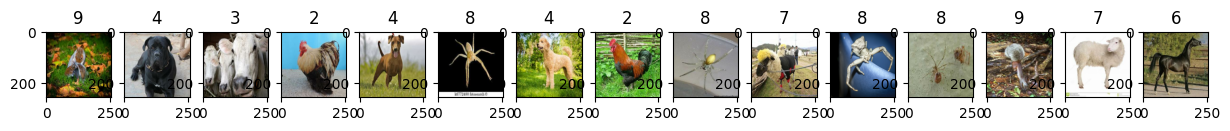

In [10]:
fig, ax = plt.subplots(ncols=15, figsize=(15,15))
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## Split Data

In [11]:
#NUMBER OF BATCHES OF DATA, 100% OF DATA
len(data)

819

In [9]:
#Splitting 819 into train and test (ADDED 2 TO ACCOUNT FOR ROUNDING)
train_size = int(len(data)*.7)+1
val_size=int(len(data)*.2)
test_size=int(len(data)*.1)+1

In [10]:
train_size + val_size + test_size

819

In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [12]:
tf.autograph.set_verbosity(
    level=0, alsologtostdout=False
)

# Deep model

## Build deep learning Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(128, (3,3),1, activation = 'relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D()) #alternative AveragePooling2D()
model.add(Dropout(.25)) 

model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())


model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(.25))




model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(.25))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

In [30]:
tf.keras.optimizers.Adam(learning_rate=0.0001)

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [32]:
#model.compile('adam', loss=tf.losses.Binarycrossentropy(), metrics = ['accuracy']) 2-class model
#model.compile('adam', loss=tf.losses.categorical_crossentropy(), metrics = ['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 128)     3584      
                                                                 
 batch_normalization_3 (Batc  (None, 254, 254, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 128)    0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 128)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 batch_normalization_4 (Batc  (None, 125, 125, 64)    

## Train

In [34]:
logdir = 'logs'

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
hist = model.fit(train, epochs = 20, validation_data =val, callbacks = [tensorboard_callback])

Epoch 1/20


2022-11-28 06:02:09.865477: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 11/574 [..............................] - ETA: 4:19 - loss: 2.7696 - accuracy: 0.1449

2022-11-28 06:02:19.103641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/574 [=>............................] - ETA: 4:06 - loss: 2.4863 - accuracy: 0.1633

2022-11-28 06:02:32.466974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/574 [====>.........................] - ETA: 3:32 - loss: 2.3092 - accuracy: 0.1928

2022-11-28 06:03:06.097918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/574 [=====>........................] - ETA: 3:28 - loss: 2.2990 - accuracy: 0.1939

2022-11-28 06:03:10.238859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/574 [=====>........................] - ETA: 3:25 - loss: 2.2919 - accuracy: 0.1955

2022-11-28 06:03:13.471278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/574 [===========>..................] - ETA: 2:36 - loss: 2.1926 - accuracy: 0.2298

2022-11-28 06:04:02.537771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/574 [============>.................] - ETA: 2:30 - loss: 2.1813 - accuracy: 0.2348

2022-11-28 06:04:09.021038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/574 [=============>................] - ETA: 2:19 - loss: 2.1570 - accuracy: 0.2439

2022-11-28 06:04:19.719433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/574 [=============>................] - ETA: 2:17 - loss: 2.1545 - accuracy: 0.2450

2022-11-28 06:04:21.574834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/574 [=============>................] - ETA: 2:16 - loss: 2.1514 - accuracy: 0.2461

2022-11-28 06:04:22.500626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/574 [==============>...............] - ETA: 2:07 - loss: 2.1388 - accuracy: 0.2518

2022-11-28 06:04:31.780817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


376/574 [==================>...........] - ETA: 1:31 - loss: 2.0841 - accuracy: 0.2709

2022-11-28 06:05:08.137693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


389/574 [===================>..........] - ETA: 1:25 - loss: 2.0762 - accuracy: 0.2743

2022-11-28 06:05:14.206979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


438/574 [=====================>........] - ETA: 1:03 - loss: 2.0494 - accuracy: 0.2842

2022-11-28 06:05:37.090673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


482/574 [========================>.....] - ETA: 42s - loss: 2.0301 - accuracy: 0.2906

2022-11-28 06:05:57.628232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


517/574 [==========================>...] - ETA: 26s - loss: 2.0135 - accuracy: 0.2958

2022-11-28 06:06:13.964207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


521/574 [==========================>...] - ETA: 24s - loss: 2.0115 - accuracy: 0.2960

2022-11-28 06:06:15.840088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


533/574 [==========================>...] - ETA: 19s - loss: 2.0072 - accuracy: 0.2975

2022-11-28 06:06:21.418572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


574/574 [==============================] - ETA: 0s - loss: 1.9893 - accuracy: 0.3036

2022-11-28 06:06:41.280939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:06:41.814696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:06:43.244153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:06:43.400948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:06:43.525698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:06:45.798738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:06:46.055508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:06:46.465849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:06:46.538130: W tensorflow/core/lib/png/png_io.cc:88] PNG 

574/574 [==============================] - 292s 499ms/step - loss: 1.9893 - accuracy: 0.3036 - val_loss: 1.9571 - val_accuracy: 0.3322
Epoch 2/20
 11/574 [..............................] - ETA: 4:22 - loss: 1.7565 - accuracy: 0.3750

2022-11-28 06:07:05.638012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/574 [=>............................] - ETA: 4:09 - loss: 1.7152 - accuracy: 0.3984

2022-11-28 06:07:19.196229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/574 [====>.........................] - ETA: 3:35 - loss: 1.6916 - accuracy: 0.4159

2022-11-28 06:07:53.366516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/574 [=====>........................] - ETA: 3:31 - loss: 1.6916 - accuracy: 0.4173

2022-11-28 06:07:57.582234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/574 [=====>........................] - ETA: 3:28 - loss: 1.6910 - accuracy: 0.4162

2022-11-28 06:08:00.854562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/574 [===========>..................] - ETA: 2:38 - loss: 1.6601 - accuracy: 0.4254

2022-11-28 06:08:50.474561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/574 [============>.................] - ETA: 2:32 - loss: 1.6531 - accuracy: 0.4295

2022-11-28 06:08:56.999756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/574 [=============>................] - ETA: 2:21 - loss: 1.6482 - accuracy: 0.4313

2022-11-28 06:09:07.777680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/574 [=============>................] - ETA: 2:19 - loss: 1.6459 - accuracy: 0.4327

2022-11-28 06:09:09.636456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/574 [=============>................] - ETA: 2:18 - loss: 1.6453 - accuracy: 0.4330

2022-11-28 06:09:10.568419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/574 [==============>...............] - ETA: 2:09 - loss: 1.6368 - accuracy: 0.4365

2022-11-28 06:09:19.905213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


376/574 [==================>...........] - ETA: 1:32 - loss: 1.6162 - accuracy: 0.4407

2022-11-28 06:09:56.452883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


389/574 [===================>..........] - ETA: 1:26 - loss: 1.6132 - accuracy: 0.4417

2022-11-28 06:10:02.546481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


438/574 [=====================>........] - ETA: 1:03 - loss: 1.6049 - accuracy: 0.4447

2022-11-28 06:10:25.564597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


482/574 [========================>.....] - ETA: 43s - loss: 1.5994 - accuracy: 0.4461

2022-11-28 06:10:46.249479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


517/574 [==========================>...] - ETA: 26s - loss: 1.5900 - accuracy: 0.4490

2022-11-28 06:11:02.719839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


521/574 [==========================>...] - ETA: 24s - loss: 1.5904 - accuracy: 0.4485

2022-11-28 06:11:04.602276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


533/574 [==========================>...] - ETA: 19s - loss: 1.5890 - accuracy: 0.4482

2022-11-28 06:11:10.230832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


574/574 [==============================] - ETA: 0s - loss: 1.5804 - accuracy: 0.4526

2022-11-28 06:11:30.020801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:11:30.552006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:11:31.959260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:11:32.118437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:11:32.238492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:11:34.501017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:11:34.756630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:11:35.164369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:11:35.236880: W tensorflow/core/lib/png/png_io.cc:88] PNG 

574/574 [==============================] - 289s 503ms/step - loss: 1.5804 - accuracy: 0.4526 - val_loss: 1.6048 - val_accuracy: 0.4498
Epoch 3/20
 11/574 [..............................] - ETA: 4:23 - loss: 1.4839 - accuracy: 0.4801

2022-11-28 06:11:54.453215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/574 [=>............................] - ETA: 4:09 - loss: 1.4712 - accuracy: 0.4984

2022-11-28 06:12:08.013050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/574 [====>.........................] - ETA: 3:35 - loss: 1.4638 - accuracy: 0.5006

2022-11-28 06:12:42.204797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/574 [=====>........................] - ETA: 3:31 - loss: 1.4633 - accuracy: 0.4990

2022-11-28 06:12:46.423534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/574 [=====>........................] - ETA: 3:28 - loss: 1.4643 - accuracy: 0.4978

2022-11-28 06:12:49.714873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/574 [===========>..................] - ETA: 2:38 - loss: 1.4335 - accuracy: 0.5009

2022-11-28 06:13:39.425415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/574 [============>.................] - ETA: 2:32 - loss: 1.4311 - accuracy: 0.5029

2022-11-28 06:13:45.991201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/574 [=============>................] - ETA: 2:21 - loss: 1.4288 - accuracy: 0.5039

2022-11-28 06:13:56.804958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/574 [=============>................] - ETA: 2:19 - loss: 1.4292 - accuracy: 0.5038

2022-11-28 06:13:58.698361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/574 [=============>................] - ETA: 2:18 - loss: 1.4292 - accuracy: 0.5042

2022-11-28 06:13:59.631710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/574 [==============>...............] - ETA: 2:09 - loss: 1.4211 - accuracy: 0.5073

2022-11-28 06:14:09.023270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


376/574 [==================>...........] - ETA: 1:32 - loss: 1.4094 - accuracy: 0.5130

2022-11-28 06:14:45.690863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


389/574 [===================>..........] - ETA: 1:26 - loss: 1.4034 - accuracy: 0.5160

2022-11-28 06:14:51.798235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


438/574 [=====================>........] - ETA: 1:03 - loss: 1.3973 - accuracy: 0.5164

2022-11-28 06:15:14.829582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


482/574 [========================>.....] - ETA: 43s - loss: 1.3892 - accuracy: 0.5187

2022-11-28 06:15:35.484513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


517/574 [==========================>...] - ETA: 26s - loss: 1.3860 - accuracy: 0.5198

2022-11-28 06:15:51.887056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


521/574 [==========================>...] - ETA: 24s - loss: 1.3876 - accuracy: 0.5197

2022-11-28 06:15:53.765344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


533/574 [==========================>...] - ETA: 19s - loss: 1.3863 - accuracy: 0.5196

2022-11-28 06:15:59.403301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


574/574 [==============================] - ETA: 0s - loss: 1.3795 - accuracy: 0.5219

2022-11-28 06:16:19.271579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:16:19.894744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:16:21.462482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:16:21.616939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:16:21.740228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:16:23.998691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:16:24.251988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:16:24.657555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:16:24.728322: W tensorflow/core/lib/png/png_io.cc:88] PNG 

574/574 [==============================] - 289s 504ms/step - loss: 1.3795 - accuracy: 0.5219 - val_loss: 1.6079 - val_accuracy: 0.4371
Epoch 4/20
 11/574 [..............................] - ETA: 4:23 - loss: 1.3861 - accuracy: 0.5568

2022-11-28 06:17:16.395708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/574 [=>............................] - ETA: 4:09 - loss: 1.3611 - accuracy: 0.5367

2022-11-28 06:17:29.904571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/574 [====>.........................] - ETA: 3:35 - loss: 1.3220 - accuracy: 0.5498

2022-11-28 06:18:03.975176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/574 [=====>........................] - ETA: 3:30 - loss: 1.3232 - accuracy: 0.5471

2022-11-28 06:18:08.181774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/574 [=====>........................] - ETA: 3:27 - loss: 1.3309 - accuracy: 0.5443

2022-11-28 06:18:11.460365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/574 [===========>..................] - ETA: 2:38 - loss: 1.2957 - accuracy: 0.5524

2022-11-28 06:19:00.928508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/574 [============>.................] - ETA: 2:31 - loss: 1.2941 - accuracy: 0.5537

2022-11-28 06:19:07.456480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/574 [=============>................] - ETA: 2:20 - loss: 1.2926 - accuracy: 0.5531

2022-11-28 06:19:18.197506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/574 [=============>................] - ETA: 2:19 - loss: 1.2914 - accuracy: 0.5537

2022-11-28 06:19:20.063985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/574 [=============>................] - ETA: 2:18 - loss: 1.2915 - accuracy: 0.5535

2022-11-28 06:19:20.990197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/574 [==============>...............] - ETA: 2:08 - loss: 1.2810 - accuracy: 0.5575

2022-11-28 06:19:30.304331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


376/574 [==================>...........] - ETA: 1:32 - loss: 1.2682 - accuracy: 0.5608

2022-11-28 06:20:06.721149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


389/574 [===================>..........] - ETA: 1:26 - loss: 1.2656 - accuracy: 0.5619

2022-11-28 06:20:12.781826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


438/574 [=====================>........] - ETA: 1:03 - loss: 1.2602 - accuracy: 0.5634

2022-11-28 06:20:35.646842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


482/574 [========================>.....] - ETA: 42s - loss: 1.2569 - accuracy: 0.5653

2022-11-28 06:20:56.239028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


517/574 [==========================>...] - ETA: 26s - loss: 1.2516 - accuracy: 0.5675

2022-11-28 06:21:12.612904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


521/574 [==========================>...] - ETA: 24s - loss: 1.2530 - accuracy: 0.5672

2022-11-28 06:21:14.506298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


533/574 [==========================>...] - ETA: 19s - loss: 1.2522 - accuracy: 0.5665

2022-11-28 06:21:20.089273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


574/574 [==============================] - ETA: 0s - loss: 1.2499 - accuracy: 0.5662

2022-11-28 06:21:39.767087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:21:40.299569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:21:41.712150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:21:41.867531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:21:41.991534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:21:44.258737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:21:44.509202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:21:44.910254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 06:21:44.984076: W tensorflow/core/lib/png/png_io.cc:88] PNG 

574/574 [==============================] - 288s 501ms/step - loss: 1.2499 - accuracy: 0.5662 - val_loss: 1.4295 - val_accuracy: 0.5171
Epoch 5/20
 11/574 [..............................] - ETA: 4:22 - loss: 1.2162 - accuracy: 0.6051

2022-11-28 06:22:04.116636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/574 [=>............................] - ETA: 4:09 - loss: 1.2297 - accuracy: 0.5781

2022-11-28 06:22:17.658067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/574 [====>.........................] - ETA: 3:35 - loss: 1.1978 - accuracy: 0.5896

2022-11-28 06:22:51.742050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/574 [=====>........................] - ETA: 3:30 - loss: 1.1948 - accuracy: 0.5920

2022-11-28 06:22:55.936473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/574 [=====>........................] - ETA: 3:27 - loss: 1.1969 - accuracy: 0.5908

2022-11-28 06:22:59.216749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/574 [===========>..................] - ETA: 2:38 - loss: 1.1724 - accuracy: 0.5987

2022-11-28 06:23:48.791954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/574 [============>.................] - ETA: 2:31 - loss: 1.1747 - accuracy: 0.5971

2022-11-28 06:23:55.348304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/574 [=============>................] - ETA: 2:21 - loss: 1.1700 - accuracy: 0.5995

2022-11-28 06:24:06.125216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/574 [=============>................] - ETA: 2:19 - loss: 1.1664 - accuracy: 0.6013

2022-11-28 06:24:07.990614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/574 [=============>................] - ETA: 2:18 - loss: 1.1647 - accuracy: 0.6018

2022-11-28 06:24:08.918774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/574 [==============>...............] - ETA: 2:09 - loss: 1.1580 - accuracy: 0.6033

2022-11-28 06:24:18.279018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


376/574 [==================>...........] - ETA: 1:32 - loss: 1.1480 - accuracy: 0.6077

2022-11-28 06:24:54.833477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


389/574 [===================>..........] - ETA: 1:26 - loss: 1.1462 - accuracy: 0.6102

2022-11-28 06:25:00.924964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


423/574 [=====================>........] - ETA: 1:10 - loss: 1.1418 - accuracy: 0.6103

KeyboardInterrupt: 

In [24]:
hist.history

{'loss': [1.9624965190887451,
  1.6282203197479248,
  1.457903265953064,
  1.3335645198822021,
  1.2372572422027588],
 'accuracy': [0.31266331672668457,
  0.4390243887901306,
  0.498584508895874,
  0.5399608016014099,
  0.5783972144126892],
 'val_loss': [1.8513610363006592,
  1.532577633857727,
  1.3772937059402466,
  1.3682336807250977,
  1.2649613618850708],
 'val_accuracy': [0.3623466193675995,
  0.47680214047431946,
  0.516487717628479,
  0.5391104221343994,
  0.5674846768379211]}

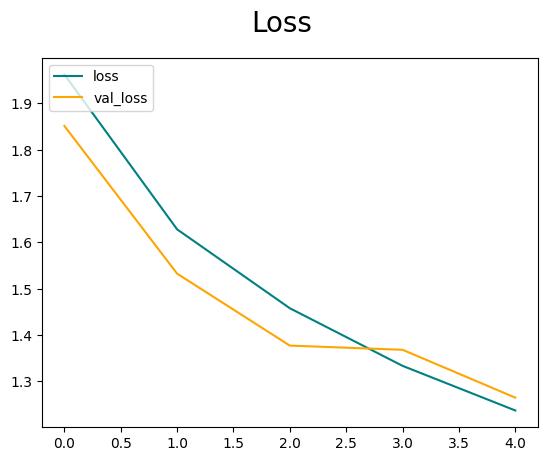

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc="upper left")
plt.show()

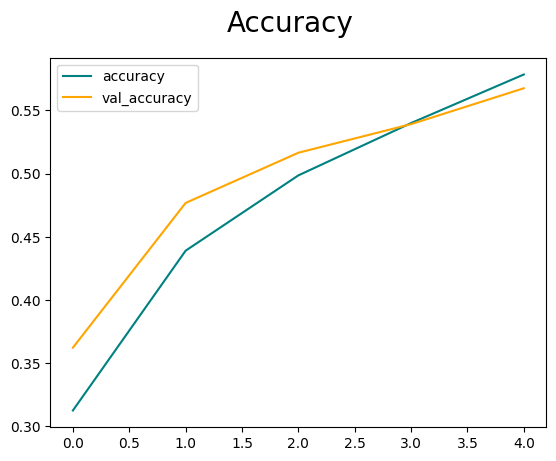

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evalue Performance

## Evaluate

In [114]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [116]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

## Test

In [371]:
import cv2

In [372]:
img = cv2.imread('../Resources/Test/cattttt.jpg')

In [373]:
imgDog = cv2.imread('../Resources/Test/dogML.jpg')
resizeDog = tf.image.resize(imgDog, (256,256))
np.expand_dims(resizeDog, 0).shape

(1, 256, 256, 3)

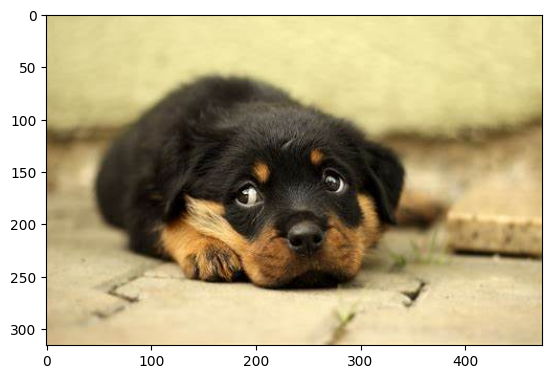

In [374]:
plt.imshow(imgDog)
plt.imshow(cv2.cvtColor(imgDog, cv2.COLOR_BGR2RGB))

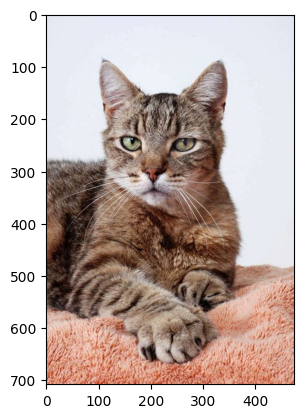

In [375]:
plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

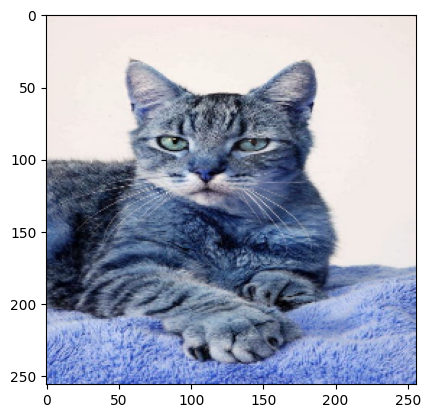

In [376]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [377]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [378]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 21ms/step


In [379]:
dogHat = model.predict(np.expand_dims(resizeDog/255,0))

1/1 [==============================] - 0s 20ms/step


In [380]:
yhat

array([[3.5416484e-02, 9.7297244e-02, 4.4675354e-02, 4.8276546e-04,
        4.5475408e-02, 6.1598787e-04, 2.1658551e-02, 1.4017218e-03,
        7.3856151e-01, 1.4414973e-02]], dtype=float32)

In [381]:
# THIS TESTS CAT PICTURE IF WORKS
np.argmax(yhat, axis =1)

array([8])

In [382]:
# THIS TESTS DOG PICTURE IF WORKS
np.argmax(dogHat, axis =1)

array([4])